<a href="https://colab.research.google.com/github/gs3541/Data-Privacy/blob/main/SHAP_DATA_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RDS Homework 3 Template
## Spring 2023


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [4]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [5]:
import pandas as pd

df_train = pd.DataFrame({'text': newsgroups_train.data, 'label': newsgroups_train.target})
df_test = pd.DataFrame({'text': newsgroups_test.data, 'label': newsgroups_test.target})

In [6]:
# Initialize & fit tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_train.shape

(1079, 10407)

In [7]:
X_test = vectorizer.transform(newsgroups_test.data)
X_test.shape

(717, 10407)

In [8]:
# Train & fit the classifier 
from sklearn.metrics import accuracy_score
clf = SGDClassifier()
clf.fit(X_train,newsgroups_train.target)

SGDClassifier()

In [9]:
y_pred = clf.predict(X_test)

In [10]:
print(accuracy_score(newsgroups_test.target,y_pred))

0.9260808926080892


### Part (B)

In [11]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(newsgroups_test.target, y_pred)
print(cm)

[[273  46]
 [  7 391]]


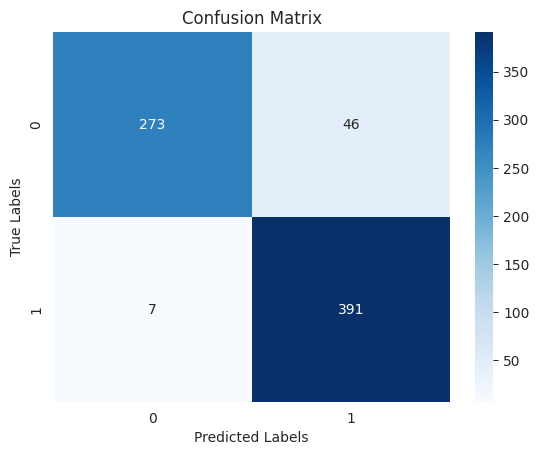

In [12]:
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:
len(y_pred)

717

Lets find some missclassified indexes.

In [61]:
k = len(y_pred) - 500
for i in range(k):
  if(y_pred[i] != newsgroups_test.target[i]):
    print(i)

0
1
25
38
54
62
75
94
99
107
110
121
123
126
134
148
197
216


#### Explainer

In [24]:
# Initialize the explainer and apply to test data
import shap
shap.initjs()
explainer = shap.LinearExplainer(clf,X_train)

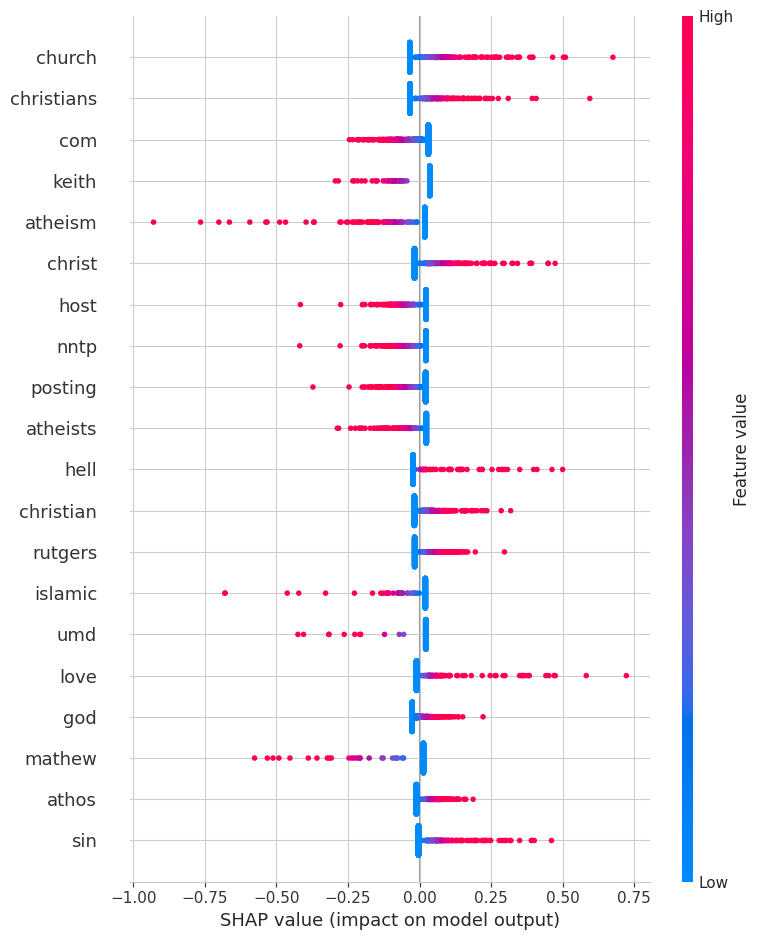

In [25]:
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

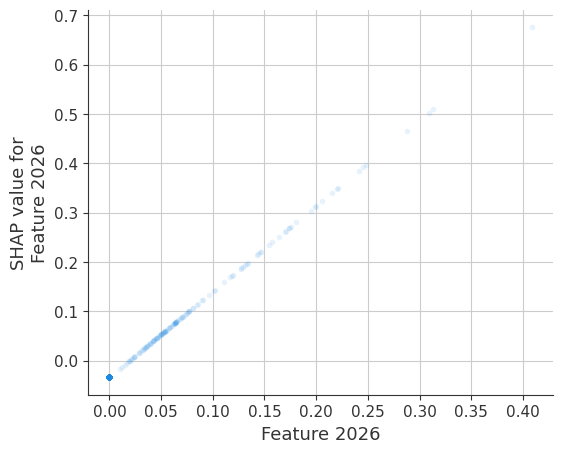

In [26]:
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("church"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

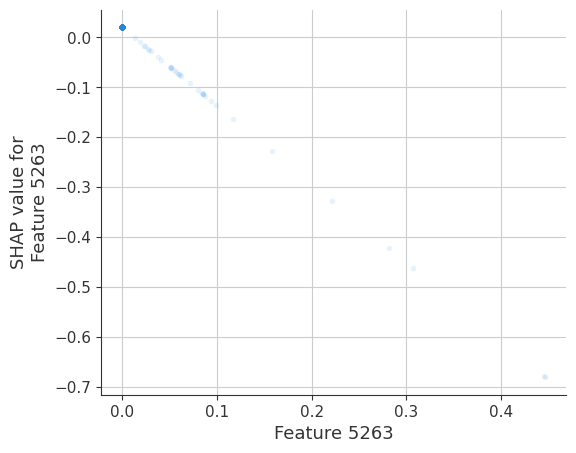

In [27]:
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("islamic"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

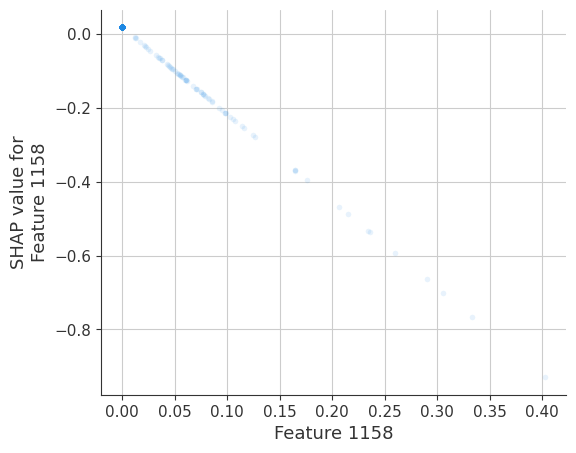

In [28]:
shap.dependence_plot(vectorizer.get_feature_names_out().tolist().index("atheism"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

In [48]:
# Visually explain 5 documents selected from the test set
shap.initjs()
idx = 8
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)


Christianity


##This index=8 is correctly classified as christianity.

In [49]:
shap.initjs()
idx = 54
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Christianity


##This index=54 is missclassified as christianity while the outcome should be atheism as our shap value is lower than the base value

In [40]:
shap.initjs()
idx = 412
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Atheism


##This index=412 is correctly classified as atheism as the value is less thsan the base value.

In [51]:
shap.initjs()
idx = 21
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Christianity


##This index=21 is correctly classified as christianity.

In [53]:
shap.initjs()
idx = 0
print("Christianity" if newsgroups_test.target[idx] else "Atheism")
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], X_test_array[idx,:],
    feature_names=vectorizer.get_feature_names_out()
)

Christianity


##This index=0 is missclassified as christianity while the outcome should be atheism as our shap value is lower than the base value

### Part (C)


#### Part (i)

In [62]:
# Compute the accuracy of the classifier and the number of misclassified documents

print("Accuracy of our Classifier : ",accuracy_score(newsgroups_test.target,y_pred))

Accuracy of our Classifier :  0.9260808926080892


In [63]:
from sklearn.metrics import zero_one_loss

print("Number of misclassified documents : ",zero_one_loss(newsgroups_test.target,y_pred,normalize=False))

Number of misclassified documents :  53


In [65]:
import numpy as np

misclassified_indexes = np.where(newsgroups_test.target != y_pred)
print(misclassified_indexes)

(array([  0,   1,  25,  38,  54,  62,  75,  94,  99, 107, 110, 121, 123,
       126, 134, 148, 197, 216, 223, 242, 245, 271, 280, 377, 399, 406,
       413, 419, 438, 442, 447, 460, 461, 469, 514, 558, 568, 581, 591,
       607, 610, 615, 620, 623, 630, 641, 658, 668, 677, 683, 685, 694,
       703]),)


#### Part (ii)

In [ ]:
# Calculate conf_i for all misclassified documents 
from sklearn.metrics import log_loss



In [ ]:
# Plot conf_i

#### Part (iii)

In [ ]:
# Identify tokens (word_j) that contributed to the misclassification of documents

In [ ]:
# Compute the number of documents (count_j) these words helped to misclassify

In [ ]:
# Compute the sum of absolute SHAP values (weight_j) for each word_j

In [ ]:
# Plot the distribution of count_j and weight_j

### Part (D)

In [ ]:
# Implement a strategy for feature selection

In [ ]:
# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection